In [1]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
import gensim.models as genmodels
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt


from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

D:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# Load Data

In [2]:
#df_facilities = pickle.load(open("../data/hotel_info_final2.pkl", "rb"))
df_facilities = pickle.load(open("../data/archive/hotel_info_final2.pkl", "rb"))
df0=df_facilities 
display(df_facilities.shape)
display(df_facilities.columns)
df_facilities=df_facilities[[#'description',
                            'all_facilities',
                            'review_rating',
                            ]]
df_facilities

(307, 20)

Index(['hotel_name_', 'stars', 'location', 'review_rating', 'description',
       'main_facilities', 'total_reviews', 'sub_ratings',
       'sub_ratings_categories', 'sub_ratings_dict', 'hotel_surroundings',
       'hotel_surroundings_distance', 'surroundings_dict', 'room_type',
       'price_list', 'cheapest_price', 'facilities_groups', 'all_facilities',
       'link', 'room_price_dict'],
      dtype='object')

,all_facilities,review_rating
0,"[[Toilet paper, Towels, Towels/Sheets (extra f...",6.0
1,"[[Toilet paper, Towels, Additional bathroom, B...",8.0
2,"[[Toilet paper, Towels, Bidet, Guest bathroom,...",7.3
3,"[[Private Bathroom, Toilet, Free toiletries, S...",7.8
4,"[[TV], [Daily housekeeping, Concierge], [Fire ...",6.8
...,...,...
302,"[[Toilet paper, Towels, Towels/Sheets (extra f...",6.9
303,"[[Toilet paper, Towels, Bidet, Slippers, Priva...",6.8
304,"[[Themed dinners, Temporary art galleries], [C...",8.1
305,"[[Toilet paper, Towels, Towels/Sheets (extra f...",7.3


In [3]:
df_facilities.all_facilities[0]

[['Toilet paper',
  'Towels',
  'Towels/Sheets (extra fee)',
  'Toilet',
  'Free toiletries',
  'Shower'],
 ['Linens'],
 ['Flat-screen TV', 'Satellite channels'],
 ['24-hour front desk'],
 ['Fire extinguishers',
  'Smoke alarms',
  'Security alarm',
  'Key access',
  '24-hour security'],
 ['Designated smoking area',
  'Air conditioning',
  'Smoke-free property',
  'Family rooms',
  'Non-smoking rooms'],
 ['English', 'Filipino']]

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend([r'(extra fee)'])

In [5]:
#df = pickle.load(open("../data/merged_hotel_data.pkl", "rb"))
df=df_facilities
df=df.replace(r'^\s*$', np.nan, regex=True)
print(df.shape)
#df.head()


(307, 2)


In [6]:
#default_comments=[r"extra fee"]

#pattern = '|'.join(default_comments)
df_reviews_sr=df[['review_rating',"all_facilities"]].dropna()
#df_reviews_sr=df_reviews_sr[~df_reviews_sr.all_facilities.str.contains(pattern)]
#df_reviews_sr

def flatten(l):
    return [item for sublist in l for item in sublist]

df_reviews_sr["flat_facilities"]=df_reviews_sr["all_facilities"].apply(lambda x: ' '.join([item for sublist in x for item in sublist]))
#df_reviews_sr["flat_facilities"]=df_reviews_sr["all_facilities"].apply(lambda x: [item for sublist in x for item in sublist])
df_reviews_sr

,review_rating,all_facilities,flat_facilities
0,6.0,"[[Toilet paper, Towels, Towels/Sheets (extra f...",Toilet paper Towels Towels/Sheets (extra fee) ...
1,8.0,"[[Toilet paper, Towels, Additional bathroom, B...",Toilet paper Towels Additional bathroom Bidet ...
2,7.3,"[[Toilet paper, Towels, Bidet, Guest bathroom,...",Toilet paper Towels Bidet Guest bathroom Slipp...
3,7.8,"[[Private Bathroom, Toilet, Free toiletries, S...",Private Bathroom Toilet Free toiletries Shower...
4,6.8,"[[TV], [Daily housekeeping, Concierge], [Fire ...",TV Daily housekeeping Concierge Fire extinguis...
...,...,...,...
302,6.9,"[[Toilet paper, Towels, Towels/Sheets (extra f...",Toilet paper Towels Towels/Sheets (extra fee) ...
303,6.8,"[[Toilet paper, Towels, Bidet, Slippers, Priva...",Toilet paper Towels Bidet Slippers Private Bat...
304,8.1,"[[Themed dinners, Temporary art galleries], [C...",Themed dinners Temporary art galleries Coffee ...
305,7.3,"[[Toilet paper, Towels, Towels/Sheets (extra f...",Toilet paper Towels Towels/Sheets (extra fee) ...


In [7]:
# Convert to list 
data = df_reviews_sr.flat_facilities.values.tolist()  
# # Remove Emails 
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# # Remove new line characters 
# data = [re.sub('\s+', ' ', sent) for sent in data]  
# # Remove distracting single quotes 
# data = [re.sub("\'", "", sent) for sent in data]
# #Remove \n
# data = [re.sub("\n", "", sent) for sent in data]
# data = [re.sub("(Image courtesy: )", "", sent) for sent in data]
# #Remove links
# data = [re.sub(r'http\S+', '', sent) for sent in data]
display(len(data))
print(data[1])

307

Toilet paper Towels Additional bathroom Bidet Towels/Sheets (extra fee) Guest bathroom Bathtub or shower Slippers Shared toilet Toilet Free toiletries Hairdryer Shower Linens Alarm clock City view View Outdoor furniture Outdoor dining area Outdoor furniture BBQ facilities Patio Terrace Garden Shared kitchen Dining table Coffee machine Cleaning products Toaster Stovetop Oven Dryer Kitchenware Electric kettle Kitchen Washing machine Microwave Refrigerator Kitchenette Socket near the bed Bingo Casino Golf course (within 2 miles) Tennis court Dining area Sitting area Desk iPad Fruit Wine/Champagne Breakfast in the room Restaurant Tea/Coffee maker Street parking Baggage storage 24-hour front desk Board games/Puzzles Books, DVDs or music for children Board games/puzzles Child safety socket covers Daily housekeeping Suit press Ironing service Dry cleaning Laundry Fax/Photocopying Business center Fire extinguishers CCTV outside property Key access 24-hour security Safe Grocery deliveries Share

### Tokenization

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1]) 

[['toilet', 'paper', 'towels', 'towels', 'sheets', 'extra', 'fee', 'toilet', 'free', 'toiletries', 'shower', 'linens', 'flat', 'screen', 'tv', 'satellite', 'channels', 'hour', 'front', 'desk', 'fire', 'extinguishers', 'smoke', 'alarms', 'security', 'alarm', 'key', 'access', 'hour', 'security', 'designated', 'smoking', 'area', 'air', 'conditioning', 'smoke', 'free', 'property', 'family', 'rooms', 'non', 'smoking', 'rooms', 'english', 'filipino']]


# Building the bigram and trigram Models (Shortcut)

In [9]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)


In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])
#print(bigram_mod[data_words[1]])

['toilet', 'paper', 'towels', 'additional', 'bathroom', 'bidet', 'towels', 'sheets', 'extra', 'fee', 'guest', 'bathroom', 'bathtub', 'or', 'shower', 'slippers', 'shared', 'toilet', 'toilet', 'free', 'toiletries', 'hairdryer', 'shower', 'linens', 'alarm', 'clock', 'city', 'view', 'view', 'outdoor', 'furniture', 'outdoor', 'dining', 'area', 'outdoor', 'furniture', 'bbq', 'facilities', 'patio', 'terrace', 'garden', 'shared', 'kitchen', 'dining', 'table', 'coffee', 'machine', 'cleaning', 'products', 'toaster', 'stovetop', 'oven', 'dryer', 'kitchenware', 'electric', 'kettle', 'kitchen', 'washing', 'machine', 'microwave', 'refrigerator', 'kitchenette', 'socket', 'near', 'the', 'bed', 'bingo', 'casino', 'golf', 'course', 'within', 'miles', 'tennis', 'court', 'dining', 'area', 'sitting', 'area', 'desk', 'ipad', 'fruit', 'wine', 'champagne', 'breakfast', 'in', 'the', 'room', 'restaurant', 'tea', 'coffee', 'maker', 'street', 'parking', 'baggage', 'storage', 'hour', 'front', 'desk', 'board_games'

### Define function for stopwords, bigrams, trigrams and lemmatization

In [11]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


In [13]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#nlp = spacy.load('en_core_web_lg')
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
#['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_tri = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized_bi[-1])

D:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


['toilet', 'paper', 'towel', 'bidet', 'towel', 'sheet', 'extra', 'fee', 'slipper', 'private', 'bathroom', 'toilet', 'free', 'toiletry', 'shower', 'linen', 'wardrobe', 'closet', 'socket', 'bed', 'clothe', 'rack', 'desk', 'flat', 'screen', 'tv', 'cable', 'channel', 'telephone', 'tv', 'pay', 'view', 'channel', 'breakfast', 'room', 'secure', 'parking', 'accessible', 'parking', 'invoice', 'provide', 'private', 'check', 'concierge', 'baggage', 'storage', 'express', 'check', 'daily', 'housekeeping', 'fax', 'photocopy', 'fire', 'extinguisher', 'cctv', 'property', 'cctv', 'common', 'area', 'smoke', 'alarm', 'security', 'alarm', 'key', 'card', 'access', 'hour', 'security', 'safe', 'shuttle', 'service', 'convenience', 'store', 'site', 'air', 'conditioning', 'smoke', 'free', 'property', 'wake', 'service', 'elevator', 'family', 'room', 'facility', 'disabled', 'guest', 'airport', 'shuttle', 'airport', 'shuttle', 'airport', 'shuttle', 'non', 'smoking', 'room', 'room', 'service', 'lowered_sink', 'toil

In [14]:
len(data_lemmatized_bi)

307

In [15]:
id2word_bi = corpora.Dictionary(data_lemmatized_bi)  
id2word_tri = corpora.Dictionary(data_lemmatized_tri)  

In [16]:
texts_bi = data_lemmatized_bi
texts_tri = data_lemmatized_tri

In [17]:
# Term Document Frequency 
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]  
corpus_tri = [id2word_tri.doc2bow(text) for text in texts_tri]  

In [18]:
# View 
print(corpus_bi[:8])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 2), (29, 2), (30, 2), (31, 1), (32, 2), (33, 1)], [(0, 1), (1, 1), (2, 2), (3, 5), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (25, 1), (26, 1), (27, 2), (29, 2), (30, 3), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 2), (57, 2), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 3), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)

In [19]:
[[(id2word_bi[id], freq) for id, freq in cp] for cp in corpus_bi[:1]]
[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri[:1]]

[[('access', 1),
  ('air', 1),
  ('alarm', 2),
  ('area', 1),
  ('channel', 1),
  ('conditioning', 1),
  ('designate', 1),
  ('desk', 1),
  ('extinguisher', 1),
  ('extra', 1),
  ('family', 1),
  ('fee', 1),
  ('fire', 1),
  ('flat', 1),
  ('free', 2),
  ('front', 1),
  ('hour', 2),
  ('key', 1),
  ('linen', 1),
  ('non', 1),
  ('paper', 1),
  ('property', 1),
  ('room', 2),
  ('satellite', 1),
  ('screen', 1),
  ('security', 2),
  ('sheet', 1),
  ('shower', 1),
  ('smoke', 2),
  ('smoking', 2),
  ('toilet', 2),
  ('toiletry', 1),
  ('towel', 2),
  ('tv', 1)]]

### Visualization

<AxesSubplot: ylabel='word'>

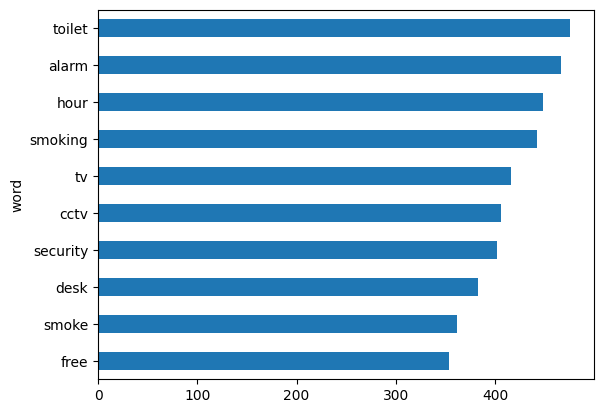

In [20]:
bow=[[(id2word_tri[id], freq) for id, freq in cp] for cp in corpus_tri]
flat_list = [item for sublist in bow for item in sublist]


#no_value_words=["stay","good","hotel","place","nice","great"]
no_value_words=["room","area","service"]

df_bow = pd.DataFrame(flat_list, columns = ['word', 'count'])
df_bow=df_bow[~df_bow.word.str.contains('|'.join(no_value_words))] 
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).tail(10).plot.barh()

<AxesSubplot: ylabel='word'>

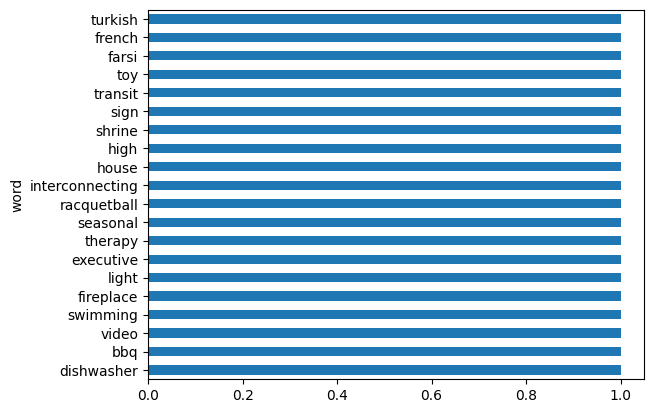

In [21]:
df_bow.groupby("word")["count"].sum().sort_values(ascending=True).head(20).plot.barh()

# Manual N-grams

In [23]:
def basic_clean(text):
    """
    A simple function to clean up the data. All the words that are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    # wnl = nltk.stem.WordNetLemmatizer()
    # stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    # text = (unicodedata.normalize('NFKD', text)
    # .encode('ascii', 'ignore')
    # .decode('utf-8', 'ignore')
    # .lower())
    
    words = re.sub(r'[^\w\s]', '', text).split()
    
    return [word for word in words]


words = basic_clean(''.join(str(data_lemmatized_tri)))
words[:20]

['toilet',
 'paper',
 'towel',
 'towel',
 'sheet',
 'extra',
 'fee',
 'toilet',
 'free',
 'toiletry',
 'shower',
 'linen',
 'flat',
 'screen',
 'tv',
 'satellite',
 'channel',
 'hour',
 'front',
 'desk']

In [24]:
pd.Series(nltk.ngrams(words, 1)).head(10)

NameError: name 'nltk' is not defined

## Visualization

In [ ]:
unigrams_series = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:10]
#unigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
unigrams_series

In [ ]:
unigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(8, 4))


In [ ]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
#unigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
bigrams_series

In [ ]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(8, 4))

In [ ]:
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
#unigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
trigrams_series

In [ ]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(8, 4))

In [ ]:
trigrams_series = (pd.Series(nltk.ngrams(words, 7)).value_counts())[:10]
#unigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]

In [ ]:
trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(8, 4))

## N-Grams Modelling

In [27]:
l=[]
for i in data_lemmatized_tri:
    list_to_append=" ".join([ii for ii in i])
    l.append(list_to_append)

In [28]:
df=df_reviews_sr[['review_rating',
                  #'flat_facilities'
                 ]]
df['review_rating']=df['review_rating'].astype(float)
df['review_rating']=np.where(df.review_rating>7.5,1,0)
df["facilities"]=l
#data=" ".join(data_lemmatized_bi)
#df["facilities"]=data_lemmatized_bi
df

C:\Users\DELL\AppData\Local\Temp\ipykernel_9836\760746785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_rating']=df['review_rating'].astype(float)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9836\760746785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_rating']=np.where(df.review_rating>7.5,1,0)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9836\760746785.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,review_rating,facilities
0,0,toilet paper towel towel sheet extra fee toile...
1,1,toilet paper towel additional bathroom bidet t...
2,0,toilet paper towel bidet guest bathroom slippe...
3,1,private bathroom toilet free toiletry shower r...
4,0,housekeeping concierge fire extinguisher cctv ...
...,...,...
302,0,toilet paper towel towel sheet extra fee priva...
303,0,toilet paper towel bidet slipper private bathr...
304,1,themed dinner temporary art gallery site fruit...
305,0,toilet paper towel towel sheet extra fee priva...


In [29]:
df.review_rating.value_counts(normalize=True)

1    0.530945
0    0.469055
Name: review_rating, dtype: float64

In [30]:
# rename columns
#df=df_reviews_sr[['review_rating','facilities']]
#df['Sentiment'] = le.fit_transform(df['Sentiment'])

# establish input and output
X = list(df['facilities'])
y = list(df['review_rating'])

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Unigram

In [31]:
# create a bag of words for with unigrams and bigrams
#cv = CountVectorizer(analyzer = 'word',ngram_range=(1,1), stop_words='english')
cv = CountVectorizer(analyzer = 'word',ngram_range=(1,1), stop_words='english')

# convert training data to bag of words
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# train naive bayes classifier
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# create predictions
y_pred = clf.predict(X_test_cv)

# find f-1 score
score = accuracy_score(y_test, y_pred,)
print('Accuracy score : {}'.format(np.round(score,4)))

Accuracy score : 0.5325


### N-Grams

In [33]:
from statistics import mean
for N in range(1,11):
    avg_score=[]
    for i in range(20):
        #print (i)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

        # convert training data to bag of words
        cv = CountVectorizer(analyzer = 'word',ngram_range=(1,N), stop_words='english')
        X_train_cv = cv.fit_transform(X_train)
        X_test_cv = cv.transform(X_test)

        # train model and generate predictions
        clf = MultinomialNB()
        clf.fit(X_train_cv, y_train)
        y_pred = clf.predict(X_test_cv)

        # compute f-1 score
        score = np.round(accuracy_score(y_test, y_pred), 4)
        avg_score.append(score)
    
    #print(avg_score)
    a_score=mean(avg_score)
    print('Accuracy score of model with n-gram range of {}: {}'.format((1,N), a_score))

Accuracy score of model with n-gram range of (1, 1): 0.61754
Accuracy score of model with n-gram range of (1, 2): 0.63117
Accuracy score of model with n-gram range of (1, 3): 0.628575
Accuracy score of model with n-gram range of (1, 4): 0.64351
Accuracy score of model with n-gram range of (1, 5): 0.65713
Accuracy score of model with n-gram range of (1, 6): 0.651305
Accuracy score of model with n-gram range of (1, 7): 0.668195
Accuracy score of model with n-gram range of (1, 8): 0.66689
Accuracy score of model with n-gram range of (1, 9): 0.6519550000000001
Accuracy score of model with n-gram range of (1, 10): 0.675975


### View CV Vector

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(df["facilities"].tolist())

In [40]:
# Select the first five documents from the data set
cv = pd.DataFrame(vectors.todense()) 
cv.columns = vectorizer.get_feature_names()
cv_matrix = cv.T
#tfidf_matrix.columns = ['hotel'+ str(i) for i in range(1, len(df["facilities"].tolist())+1)]

cv_matrix.columns =df0.hotel_name_.values
#cv_matrix['count'] = cv.sum(axis=1)

cv_matrix.T.reset_index()


D:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,index,access,accessible,additional,adult,aerobic,age,aid,air,airport,...,washing,water,waterslide,wax,welcome,wellness,wheelchair,wine,year,yoga
0,RedDoorz near East Avenue Medical Center,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Skylab Guesthouse,1,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,The Excelsior Hotel Las Piñas,1,2,0,0,0,1,0,1,3,...,0,1,0,0,1,1,0,1,1,0
3,Rothman Hotel,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,OYO 772 Remedios Apartment,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,RedDoorz at EDSA Pasay,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
303,Kabayan Hotel Pasay,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
304,"Crimson Hotel Filinvest City, Manila",1,2,0,0,0,1,0,1,3,...,0,0,0,0,1,0,1,1,1,0
305,RedDoorz @ Jardin LRT Tayuman Manila,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Export Vector

In [48]:
cv_vector=cv_matrix.T.reset_index()
cv_vector

,index,access,accessible,additional,adult,aerobic,age,aid,air,airport,...,washing,water,waterslide,wax,welcome,wellness,wheelchair,wine,year,yoga
0,RedDoorz near East Avenue Medical Center,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Skylab Guesthouse,1,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,The Excelsior Hotel Las Piñas,1,2,0,0,0,1,0,1,3,...,0,1,0,0,1,1,0,1,1,0
3,Rothman Hotel,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,OYO 772 Remedios Apartment,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,RedDoorz at EDSA Pasay,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
303,Kabayan Hotel Pasay,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
304,"Crimson Hotel Filinvest City, Manila",1,2,0,0,0,1,0,1,3,...,0,0,0,0,1,0,1,1,1,0
305,RedDoorz @ Jardin LRT Tayuman Manila,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
pickle.dump(cv_vector, open('data/facilities_count_vector.pkl', "wb"))

# TFIDF

In [ ]:
word_set=set(words)
len(word_set)

## View tfidf Vector

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(df["facilities"].tolist())

In [55]:
# Select the first five documents from the data set
tf_idf = pd.DataFrame(vectors.todense()) 
tf_idf.columns = vectorizer.get_feature_names()
tfidf_matrix = tf_idf.T
#tfidf_matrix.columns = ['hotel'+ str(i) for i in range(1, len(df["facilities"].tolist())+1)]

tfidf_matrix.columns =df0.hotel_name_.values
#tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

tfidf_matrix.T.reset_index()


D:\Eskwelabs\sprint4\dsf-c10-sprint-4\code-along\scripting_101\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,index,access,accessible,additional,adult,aerobic,age,aid,air,airport,...,washing,water,waterslide,wax,welcome,wellness,wheelchair,wine,year,yoga
0,RedDoorz near East Avenue Medical Center,0.136869,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.094465,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,Skylab Guesthouse,0.029681,0.032614,0.121678,0.0,0.0,0.000000,0.0,0.020485,0.000000,...,0.113506,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.058481,0.000000,0.0
2,The Excelsior Hotel Las Piñas,0.030894,0.067894,0.000000,0.0,0.0,0.059545,0.0,0.021323,0.147001,...,0.000000,0.126651,0.0,0.0,0.059545,0.073663,0.000000,0.060870,0.056372,0.0
3,Rothman Hotel,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.060024,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,OYO 772 Remedios Apartment,0.259632,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.179193,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,RedDoorz at EDSA Pasay,0.168160,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.116061,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
303,Kabayan Hotel Pasay,0.058973,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.040702,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
304,"Crimson Hotel Filinvest City, Manila",0.048958,0.107591,0.000000,0.0,0.0,0.094361,0.0,0.033790,0.232951,...,0.000000,0.000000,0.0,0.0,0.094361,0.000000,0.082031,0.096461,0.089333,0.0
305,RedDoorz @ Jardin LRT Tayuman Manila,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.135842,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [56]:
tfidf_matrix[["count"]].sort_values(by="count", ascending=False).head(10)

KeyError: "None of [Index(['count'], dtype='object')] are in the [columns]"

In [ ]:
spec_col="Skylab Guesthouse"
tfidf_matrix[[spec_col]].sort_values(by=spec_col, ascending=False).head(10)

#### Export Vector

In [51]:
tfidf_vector=tfidf_matrix.T.reset_index()
tfidf_vector

,index,access,accessible,additional,adult,aerobic,age,aid,air,airport,...,washing,water,waterslide,wax,welcome,wellness,wheelchair,wine,year,yoga
0,RedDoorz near East Avenue Medical Center,0.136869,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.094465,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,Skylab Guesthouse,0.029681,0.032614,0.121678,0.0,0.0,0.000000,0.0,0.020485,0.000000,...,0.113506,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.058481,0.000000,0.0
2,The Excelsior Hotel Las Piñas,0.030894,0.067894,0.000000,0.0,0.0,0.059545,0.0,0.021323,0.147001,...,0.000000,0.126651,0.0,0.0,0.059545,0.073663,0.000000,0.060870,0.056372,0.0
3,Rothman Hotel,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.060024,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,OYO 772 Remedios Apartment,0.259632,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.179193,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,RedDoorz at EDSA Pasay,0.168160,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.116061,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
303,Kabayan Hotel Pasay,0.058973,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.040702,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
304,"Crimson Hotel Filinvest City, Manila",0.048958,0.107591,0.000000,0.0,0.0,0.094361,0.0,0.033790,0.232951,...,0.000000,0.000000,0.0,0.0,0.094361,0.000000,0.082031,0.096461,0.089333,0.0
305,RedDoorz @ Jardin LRT Tayuman Manila,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.135842,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [53]:

pickle.dump(tfidf_vector, open('data/facilities_tfidf_vector.pkl', "wb"))

## Modelling

In [ ]:
# rename columns
#df=df_reviews_sr[['review_rating','facilities']]
#df['Sentiment'] = le.fit_transform(df['Sentiment'])

# establish input and output
X = list(df['facilities'])
y = list(df['review_rating'])

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Unigram

In [ ]:
# create a bag of words for with unigrams and bigrams
tfidf = TfidfVectorizer(sublinear_tf=True,norm='l2',encoding='utf-8',ngram_range=(1,1), 
                        stop_words='english')

# convert training data to bag of words
X_train_cv = tfidf.fit_transform(X_train)
X_test_cv = tfidf.transform(X_test)

# train naive bayes classifier
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)

# create predictions
y_pred = clf.predict(X_test_cv)

# find f-1 score
score = accuracy_score(y_test, y_pred,)
print('Accuracy score : {}'.format(np.round(score,4)))

In [ ]:
from statistics import mean
for N in range(1,11):
    avg_score=[]
    for i in range(20):
        #print (i)
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

        # convert training data to bag of words
        tfidf = TfidfVectorizer(sublinear_tf=True,norm='l2',encoding='utf-8',ngram_range=(1,N), 
                        stop_words='english')
        X_train_cv = tfidf.fit_transform(X_train)
        X_test_cv = tfidf.transform(X_test)

        # train model and generate predictions
        clf = MultinomialNB()
        clf.fit(X_train_cv, y_train)
        y_pred = clf.predict(X_test_cv)

        # compute f-1 score
        score = np.round(accuracy_score(y_test, y_pred), 4)
        avg_score.append(score)
    
    #print(avg_score)
    a_score=mean(avg_score)
    print('Accuracy score of model with n-gram range of {}: {}'.format((1,N), a_score))

# Noun Chunks

In [76]:
data2 = data.copy()

In [77]:
import spacy
nlp = spacy.load('en_core_web_md')

chunks = []
for i in data2:
    doc = nlp(i)

    for chunk in doc.noun_chunks:
        out = {}
        root = chunk.root
        out[root.pos_] = root
        for tok in chunk:
            if tok != root:
                out[tok.pos_] = tok
        chunks.append(out)

In [78]:
chunks

[{'PROPN': Towels, 'NOUN': paper, 'SYM': /},
 {'NOUN': fee, 'ADJ': extra},
 {'NOUN': TV, 'PROPN': Satellite, 'ADJ': Flat, 'PUNCT': -},
 {'NOUN': hour, 'NUM': 24, 'PUNCT': -, 'ADJ': front},
 {'NOUN': Smoke},
 {'NOUN': hour, 'ADJ': Key, 'NUM': 24, 'PUNCT': -},
 {'NOUN': smoking, 'VERB': Designated},
 {'PROPN': English},
 {'PROPN': Toilet, 'NOUN': paper},
 {'NOUN': fee, 'ADJ': extra},
 {'PROPN': Bathtub, 'NOUN': bathroom},
 {'NOUN': Slippers},
 {'NOUN': toilet, 'VERB': Shared},
 {'PROPN': Linens, 'NOUN': toiletries},
 {'NOUN': Cleaning, 'VERB': Shared},
 {'NOUN': bed, 'DET': the, 'PROPN': Golf},
 {'NOUN': miles, 'NUM': 2},
 {'PROPN': Champagne, 'NOUN': area, 'VERB': Sitting, 'SYM': /},
 {'NOUN': room, 'DET': the},
 {'NOUN': Baggage, 'PROPN': Street, 'SYM': /},
 {'PROPN': Board, 'NUM': 24, 'PUNCT': -, 'NOUN': desk, 'ADJ': front},
 {'PROPN': Puzzles, 'SYM': /},
 {'NOUN': DVDs},
 {'NOUN': music},
 {'NOUN': safety, 'PROPN': games, 'SYM': /},
 {'PROPN': Daily},
 {'NOUN': service, 'PROPN': Suit

In [80]:
df_chunk = pd.DataFrame.from_dict(chunks)

In [81]:
df_chunk['NOUN'] = df_chunk['NOUN'].astype(str)
df_chunk['ADJ'] = df_chunk['ADJ'].astype(str)

In [82]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return(lemmatizer.lemmatize(text))

df_chunk['NOUN_lemma'] = df_chunk.NOUN.apply(lemmatize_text)
df_chunk['ADJ_lemma'] = df_chunk.ADJ.apply(lemmatize_text)

In [83]:
def lower_text(text):
    return(text.lower())

df_chunk['NOUN_lemma'] = df_chunk.NOUN.apply(lower_text)
df_chunk['ADJ_lemma'] = df_chunk.ADJ.apply(lower_text)

In [84]:
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].astype(str)
df_chunk['ADJ_lemma'] = df_chunk['ADJ_lemma'].astype(str)
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].str.lower()
df_chunk['ADJ_lemma'] = df_chunk['ADJ_lemma'].str.lower()

In [85]:
df_chunk['NOUN_lemma'] = df_chunk['NOUN_lemma'].astype(str)

In [86]:
df_chunk

,PROPN,NOUN,SYM,ADJ,PUNCT,NUM,VERB,DET,ADP,PART,ADV,X,CCONJ,PRON,NOUN_lemma,ADJ_lemma
0,Towels,paper,/,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,paper,nan
1,NaN,fee,NaN,extra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fee,extra
2,Satellite,TV,NaN,Flat,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tv,flat
3,NaN,hour,NaN,front,-,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hour,front
4,NaN,Smoke,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,smoke,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4416,Room,rooms,NaN,smoking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rooms,smoking
4417,Toilet,sink,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sink,nan
4418,NaN,grab,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grab,nan
4419,Upper,floors,NaN,accessible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,floors,accessible


# TOP ADJECTIVES DESCRIBING TOP NOUNS

STAFF

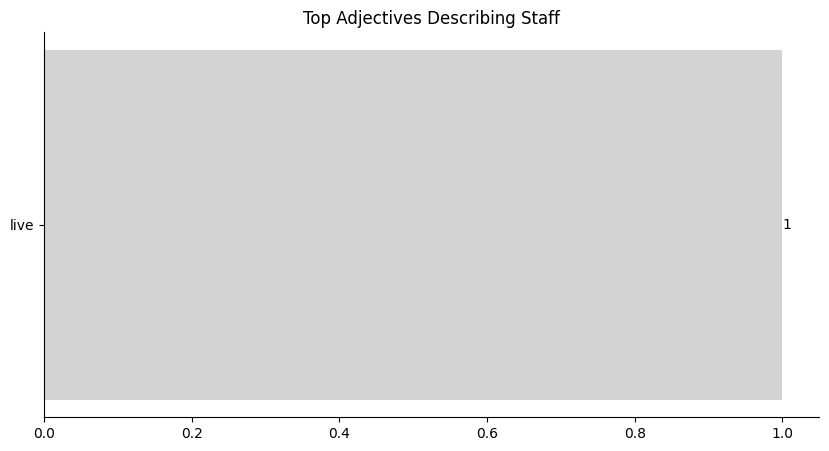

In [87]:
staff =  df_chunk[(df_chunk['NOUN_lemma'] == 'staff') & (df_chunk['ADJ_lemma'] != 'nan')]
staff = staff[['NOUN_lemma','ADJ_lemma']]


staff_adj = pd.DataFrame({'trans_count': staff['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(staff_adj.index, staff_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Staff')
ax.bar_label(hbar)
plt.show()

ROOM

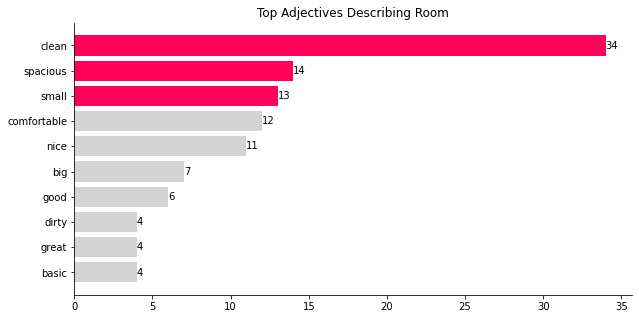

In [105]:
room =  df_chunk[(df_chunk['NOUN_lemma'] == 'room') & (df_chunk['ADJ_lemma'] != "nan")]
room = room[['NOUN_lemma','ADJ_lemma']]


room_adj = pd.DataFrame({'trans_count': room['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(room_adj.index, room_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Room')
ax.bar_label(hbar)
plt.show()

LOCATION

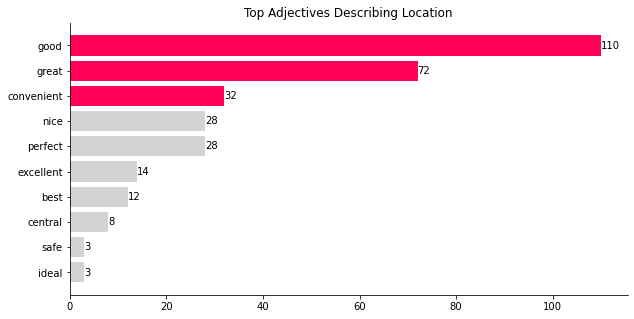

In [107]:
loct =  df_chunk[(df_chunk['NOUN_lemma'] == 'location') & (df_chunk['ADJ_lemma'] != "nan")]
loct = loct[['NOUN_lemma','ADJ_lemma']]


loct_adj = pd.DataFrame({'trans_count': loct['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(loct_adj.index, loct_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Location')
ax.bar_label(hbar)
plt.show()

SERVICE

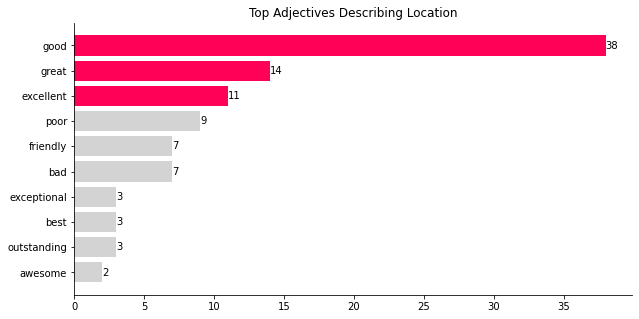

In [113]:
mon =  df_chunk[(df_chunk['NOUN_lemma'] == 'service') & (df_chunk['ADJ_lemma'] != "nan")]
mon = mon[['NOUN_lemma','ADJ_lemma']]


mon_adj = pd.DataFrame({'trans_count': mon['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(mon_adj.index, mon_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Location')
ax.bar_label(hbar)
plt.show()

PRICE

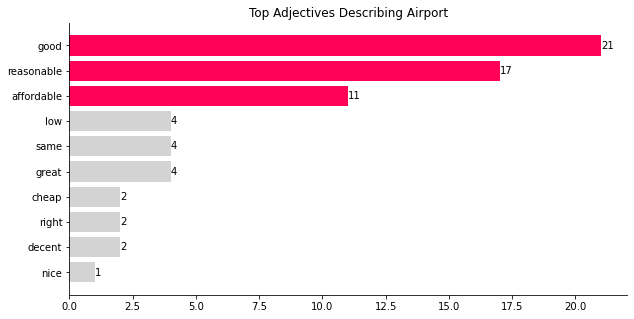

In [114]:
apt =  df_chunk[(df_chunk['NOUN_lemma'] == 'price') & (df_chunk['ADJ_lemma'] != "nan")]
apt = apt[['NOUN_lemma','ADJ_lemma']]


apt_adj = pd.DataFrame({'trans_count': apt['ADJ_lemma'].value_counts().sort_values().tail(10)})

colors_h = ['lightgray'] * 10
colors_h[7:10] = ['#ff0257'] * 3

fig, ax = plt.subplots(figsize=(10, 5))
hbar = ax.barh(apt_adj.index, apt_adj.trans_count, color=colors_h)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
ax.set_title('Top Adjectives Describing Airport')
ax.bar_label(hbar)
plt.show()